# Basic setting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

tqdm.pandas()
import numpy as np
import os
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load data

In [2]:
bills = pd.read_csv('/Users/junghyunwoo/혀누에-의한-혀누를-위한-혀누의/공부공부공부공부/대학 이후/코딩 관련/개인프로젝트_국회의원 추천 (20대)/1차 데이터 및 jupyter/bills_24839_all_cleansed.csv')
senators = pd.read_csv('/Users/junghyunwoo/혀누에-의한-혀누를-위한-혀누의/공부공부공부공부/대학 이후/코딩 관련/개인프로젝트_국회의원 추천 (20대)/1차 데이터 및 jupyter/(원본) assembly_memebers_295.csv')

## Bills dataframe preprocess

In [3]:
bills.drop(columns='bill_id', inplace=True)

In [4]:
# Change column to datetime
bills['입안일'] = pd.to_datetime(bills['입안일'])

In [5]:
bills = bills.sort_values(by='입안일')

In [6]:
bills = bills[bills['발의자'].notnull()]

## Senators dataframe preprocess

In [7]:
senators.reset_index(inplace=True)

In [8]:
senators = senators.rename(columns={'index':'senator_id'})
senators['senator_id'] = senators['senator_id'] + 1

In [9]:
senators['한글이름'] = senators['이름'].str.split(' ').str[0]
senators['한자이름'] = senators['이름'].str.split(' ').str[1]

In [10]:
senators

senator_id       이름      정당                 선거구                                           당선횟수                              소속위원회                                                                         학력                                                                                         주요경력                                           연락처                             이메일  대표발의법안수   위원회 출석률   본회의 출석률                                                  재산 한글이름 한자이름
0             1  강길부 姜吉夫     무소속              울산 울주군                      4선 [ 17대, 18대, 19대, 20대 ]                    산업통상자원중소벤처기업위원회                                   언양농업고등학교/성균관대학교 행정학과/서울대학교환경대학원 도시계획학 석사                                                                         6대 건설교통부 차관/한국감정원 원장   의원회관 606호 | 전화 02-784-5073 | 팩스 02-788-0103          shinmut@assembly.go.kr        2   93.65 %   82.88 %          총계 3,386,959 3,436,703 3,394,464 3,762,663  강길부  姜吉夫
1             2  강병원 姜炳遠  더불어민주당             서울 은평구을                                             1선                            기획재정위원회                                                       서울대학교 농업생명과학대학 농경제학과                                                                   서울대학교 총학생회장/노무현대통령 청와대 행정관   의원회관 610호 | 전화 02-784-1422 | 팩스 02-788-0118              kangbw89@gmail.com       14   98.15 %   98.63 %                  총계 662,157 754,761 888,275 989,750  강병원  姜炳遠
2             3  강석진 姜錫振   미래통합당     경남 산청군함양군거창군합천군                                             1선                      농림축산식품해양수산위원회                                                                연세대학교 행정대학원                                                                   새누리당 최경환 원내대표 비서실장/경남 거창군수   의원회관 542호 | 전화 02-784-1460 | 팩스 02-788-0119              ksjv7900@naver.com       19   98.36 %   93.84 %                  총계 365,671 472,584 532,440 724,182  강석진  姜錫振
3             4  강석호 姜碩鎬   미래통합당     경북 영양군영덕군봉화군울진군                           3선 [ 18대, 19대, 20대 ]                      농림축산식품해양수산위원회                                                       한국외국어대학교 서양어대학 스페인어과                                                         새누리당 제1사무부총장/경상북도의회 의원/스텔베르그&삼일 대표이사   의원회관 707호 | 전화 02-784-2374 | 팩스 02-788-0105                 kangsh@na.go.kr        8   88.46 %   86.99 %      총계 15,371,209 13,904,477 16,757,244 16,732,344  강석호  姜碩鎬
4             5  강창일 姜昌一  더불어민주당             제주 제주시갑                      4선 [ 17대, 18대, 19대, 20대 ]                            행정안전위원회                                                  서울대학교 국사학과/도쿄대학교대학원 문학 박사                                                                       5.18기념재단 이사/배재대학교 교무처장   의원회관 806호 | 전화 02-784-6084 | 팩스 02-788-0108           kangci@assembly.go.kr       10   83.33 %   90.41 %          총계 1,618,382 2,111,355 2,257,761 1,866,353  강창일  姜昌一
5             6  강효상 姜孝祥   미래통합당                비례대표                                             1선        공공부문 채용비리 의혹과 관련된 국정조사특별위원회                                                         서울대학교 법과대학 사법학과 졸업                                                                         TV조선 보도본부장/조선일보 편집국장   의원회관 418호 | 전화 02-784-6195 | 팩스 02-788-0400              hyoshang@gmail.com       12   88.89 %   83.56 %          총계 2,696,829 2,824,614 3,096,682 3,468,624  강효상  姜孝祥
6             7  강훈식 姜勳植  더불어민주당             충남 아산시을                                             1선                            국토교통위원회                                                               건국대학교 경영정보학과                                                            더불어민주당 아산을 지역위원장/동국대 언론정보대학원 겸임교수   의원회관 640호 | 전화 02-784-1045 | 팩스 02-788-0263             gohoonsik@gmail.com        7   83.33 %   93.84 %                  총계 333,560 209,253 298,004 506,666  강훈식  姜勳植
7             8  경대수 慶大秀   미래통합당        충북 증평군진천군음성군                                2선 [ 19대, 20대 ]                      농림축산식품해양수산위원회                                           경동고등학교/서울대학교/서울대학교 대학원 법학과 석사 수료                    

In [11]:
dict_senators = senators.to_dict('r')

# Proposed bills by senators

In [12]:
bills

입안일                                                           법안명                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 법안내용  \
23778 2016-05-30  통일경제파주특별자치시의 설치 및 파주평화경제특별구역의 조성·운영과 지원에 관한 특별법안(박정의원 등 17인)   소득 양극화와 계층분화 심화ㆍ가계부채 심화ㆍ국가부채 급증ㆍ사회갈등 심화ㆍ일자리 부족ㆍ국민행복지수 추락ㆍ저성장 장기화 등 각종 국내 문제들이 심각성을 더해 가고 있음. 근본적으로 한국 사회의 발전 잠재력이 한계에 봉착했으며, 조속한 시점에 새로운 성장동력을 찾지 못하는 한 경기침체의 늪에서 헤쳐 나오기 어려울 수 있다는 긴박한 위기 신호와 진단들이 쏟아져 나오고 있음. 대외적으로는 남북관계가 최악의 대치 상황으로 치닫고 있고, 국제 경제 리스크의 발생과 전개 양상이 예측하기 어려울 정도로 매우 복잡다단하고 다발적이며 위협적으로 흐르고 있는 상황임. 이러한 국내외의 총체적 위기 여건과 한계를 획기적으로 해소할 수 있는 궁극적 해결책이자 묘수가 될 수 있는 성장동력은 다름 아닌 남북 간의 전방위적인 협력 관계를 구축하는 것이라 할 것임. 그리고 다소간의 비용과 사회적 소요가 있을지라도 이를 능히 감수하고 한 발짝 더 나아가 ‘통일’을 이루는 것이라는 데에 학계 및 기업계는 물론 ...   
23749 2016-05-30                               산업재해보상보험법 일부개정법률안(이완영의원 등 122인)   현행법은 사업주가 제공한 교통수단이나 그에 준하는 교통수단을 이용하는 등 사업주의 지배관리하에서 출퇴근 중 발생한 사고에 대해서만 업무상 재해로 인정하여 산재보험급여를 지급하고 있음. 그러나 사업주가 제공하는 통근버스를 이용할 수 없는 근로자는 산재보험급여가 지급되지 아니하여, 공무원·교사·군인 등은 통상적인 경로와 방법으로 출퇴근 중 발생한 사고를 업무상 재해로 보호하고 있는 것과 대비하여 형평성 논란이 제기되고 있음. 따라서 통상적인 경로와 방법으로 출퇴근 하던 중 발생한 사고에 대하여 산재보험으로 보호하려는 것임.   ■ 주요내용  가. 사업주가 제공한 교통수단을 이용하는 등 사업주 지배관리하에서 출퇴근 중 발생한 사고뿐 아니라 그 밖의 통상적인 경로와 방법으로 출퇴근 중 발생한 사고도 업무상 재해로 인정하되, 출퇴근 경로 일탈 또는 중단이 있는 경우에는 그 경로 일탈 등이 일상생활에 필요한 행위에 해당하지 않는 한 당해 일탈 또는 중단 중의 사고 및 그 이후의 왕복 ...   
23748 2016-05-30                        파견근로자보호 등에 관한 법률 일부개정법률안(이완영의원 등 122인)   동 법률이 제정된 이후 파견허용 업무가 한정적으로 운영되고 있어 급변하는 노동시장 수요에 탄력적으로 대응하지 못하고 있음. 현행 32개 파견허용업무는 유지하면서도 고령자와 고소득 전문직을 대상으로 파견허용업무를 확대하여 고령화 사회의 도래에 따른 고령자의 일자리 확충 필요성에 부응하고 고소득 전문직의 재취업 촉진 및 중소？중견기업의 관련 인력수요를 적기에 충족시킬 수 있도록 하는 한편, 인력난이 심한 일부 업종에 대해서는 파견을 허용하여 기업 인력수요에 탄력적으로 대응할 수 있게 하고자 함. 또한 국민의 생명？안전과 밀접하게 관련된 업무에 파견근로자 사용을 제한하여 이들의 고용안정을 통해 대형사고를 예방하고 사고 발생 시에도 구난활동을 적극 수행할 수 있도록 함으로써 책임 있게 국민의 생명？안전을 지킬 수 있도록 하고, 파견과 도급의 구별기준을 명확히 하면서도 원·하청 상생을 위해 취해지는 조치는 파견 판단기준으로 보지 않는 등 관련 규정을 정비하고자 함.   ■ 주요내용 ...   
23747 2016-05-30                                국가 사이버안보에 관한 법률안(이철우의원 등 122인)   2009년 7.7디도스 사건 이후 지속적인 사이버공격으로 청와대는 물론 언론？금융사 전산시스템이 대량으로 파괴되는 피해가 발생하였으며, 최근의 사이버공격은 한국수력원자력과 서울메트로 등 국민생활과 직결되는 사회기반시설까지 확대되어 우리의 경제와 국가안보를 저해하는 가장 심각한 위협 중의 하나로 대두되었음. 특히 일부 지역에 국한해 발생하는 물리적 공격과 달리 사이버공격은 초국가적으로 시？공간을 초월하여 공공？민간 영역 구분이 없이 동시 다발적으로 발생함으로써 사이버위협 요인을 조기에 파악하여 차단하지 않을 경우 피해가 순식간에 확산되는 특성이 있음. 그러나 우리의 국가적 대응 활동은 공공？민간 부문이 제각각 분리, 독립 대응하고 있어 광범위한 사이버공격에 효율적인 대처가 불가한 실정임. 공공부문은 대통령훈령인 「국가사이버안전관리규정」에 근거하고 있어, 행정기관 이외 민간분야 및 입법ㆍ사법기관은 적용범위에서 제외되고, 민간 부문은 사이버공격 예방 및 대응을 위한 법률 미흡으로...   
23746 2016-05-30                                    행정규제기본법 폐지법률안(김광림의원 등 14인)                                                                                                                                                                                                                               저출산？고령화 시대 및 저성장에 대응하고 국가경쟁력 강화를 위하여 이 법에서 정하여 온 규제개혁 등과 관련된 사항을「국민행복과 일자리 창출？국가경쟁력 강화를 위한 규제개혁특별법안」을 제정하여 새롭게 규정함에 따라 이 법을 폐지하려는 것임.   참고사항  이 법률안은 김광림의원이 대표 발의한 「국민행복과 일자리 창출？국가경쟁력 강화를 위한 규제개혁특별법안」(의안번호 제25호)의 의결을 전제로 하는 것이므로 같은 법률안이 의결되지 아니하거나 수정 의결되는 경우에는 이에 맞추어 조정되어야 할 것임.   
...          ...                                                           ...                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [13]:
list_total = []
for idx in tqdm(dict_senators):
    dict_data = {}
    senator_id = idx['senator_id']
    korean_name = idx['한글이름']
    
    bills_id = sorted(bills[bills['발의자'].str.contains(korean_name)].index.tolist(), reverse=False)
    dict_data['senator_id'] = senator_id
    dict_data['bills_id'] = bills_id
    list_total.append(dict_data)

100%|██████████| 295/295 [00:04<00:00, 60.80it/s]


In [14]:
df_proposed_bills = pd.DataFrame(list_total)

In [16]:
df_proposed_bills['bills_id'] = [' '.join(map(str, l)) for l in df_proposed_bills['bills_id']]

In [17]:
df_proposed_bills

senator_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             bills_id
0             1  40 331 347 503 504 506 668 679 826 827 828 952 1021 1105 1315 1316 1387 1397 1573 1606 1622 1651 1652 1653 1655 1660 1762 1781 1810 1862 1880 1884 1909 1997 2003 2015 2022 2142 2143 2301 2643 2657 2676 2767 2780 2899 3007 3280 3568 3569 3571 3782 3847 3886 3964 3990 5079 5142 5150 5157 5346 5675 5678 5681 5690 5691 5750 5782 5822 5836 5928 5983 5984 5986 5987 6118 6131 6170 6180 6184 6187 6197 6206 6253 6409 6415 6440 6782 6819 6875 7038 7296 7690 7714 7738 7835 7914 8200 8283 8332 8430 8433...
1             2  17 244 249 250 253 254 255 256 280 281 329 345 380 381 382 443 624 756 794 795 865 866 1032 1040 1051 1052 1053 1054 1066 1068 1072 1074 1075 1081 1094 1113 1128 1137 1143 1147 1148 1153 1157 1173 1174 1175 1176 1177 1178 1181 1184 1221 1222 1225 1226 1236 1241 1245 1256 1259 1260 1269 1271 1284 1294 1381 1384 1391 1394 1411 1456 1468 1472 1477 1583 1584 1623 1629 1657 1661 1662 1678 1689 1700 1706 1709 1717 1767 1800 1801 1802 1807 1829 1852 1856 1882 1889 1894 1897 1898 1936 1937 2001 2030...
2             3  5 91 92 96 209 210 213 239 360 368 370 371 403 404 433 437 496 499 645 646 674 775 776 781 783 784 785 796 797 798 799 800 801 802 813 815 816 820 822 823 835 858 859 867 868 869 870 871 880 881 882 883 884 885 894 895 897 898 899 900 901 916 918 919 920 921 922 923 928 929 932 933 935 965 969 970 974 975 976 977 979 980 981 982 983 1007 1008 1010 1014 1017 1417 1469 1470 1483 1488 1564 1565 1773 1840 1841 2054 2064 2086 2090 2095 2179 2186 2307 2308 2311 2312 2313 2314 2423 2460 2518 2519 2...
3             4  11 60 61 62 69 71 83 104 105 160 166 168 174 175 198 200 201 227 233 268 378 400 430 431 433 437 501 502 618 619 620 621 622 623 654 655 679 681 682 684 685 686 687 688 767 775 781 783 784 785 786 810 813 815 820 822 823 835 838 839 840 841 842 843 844 850 851 894 895 897 898 899 900 901 916 918 919 920 921 922 928 929 932 933 935 946 947 956 957 960 979 1025 1026 1034 1348 1350 1352 1395 1564 1565 1605 1612 1648 1659 1711 1786 1787 1788 1795 1796 1847 1863 1871 1910 1977 2023 2074 2083 2099...
4             5  281 335 336 361 406 408 413 421 434 522 524 639 665 706 780 865 866 1075 1082 1113 1139 1151 1180 1191 1192 1208 1353 1401 1443 1471 1475 1478 1566 1583 1584 1646 1700 1714 1754 1792 1800 1801 1802 1817 1864 1881 1886 1892 1902 1918 1919 1920 1921 1922 1938 1939 1940 1950 1952 1961 1963 1964 1973 1978 1985 2000 2024 2025 2033 2039 2085 2145 2208 2243 2278 2404 2405 2406 2407 2425 2453 2645 2774 2802 2803 2824 2858 2880 2907 2969 2971 2990 2992 2997 3034 3065 3154 3155 3223 3233 3234 3235 323...
5             6  21 22 23 163 164 234 282 283 316 360 405 431 433 437 459 509 513 552 554 555 558 570 654 835 840 965 984 1036 1041 1043 1340 1382 1385 1388 1416 1417 1564 1565 1614 1634 1775 1794 1797 1838 1980 2023 2164 2194 2197 2206 2231 2232 2414 2437 2438 2461 2519 2680 2825 2826 2827 2832 2833 2841 2844 2864 2909 2915 2950 2966 3073 3074 3077 3215 3271 3614 3620 3697 3729 3760 3823 3835 4001 4284 4461 4507 4578 4581 4706 4940 4941 4942 5189 5201 5202 5220 5362 5391 5393 5430 5583 5664 5785 5794 5813 5...
6             7  17 39 88 130 131 153 203 229 240 252 253 254 255 265 275 281 315 338 346 424 443 451 458 652 666 794 795 811 817 860 1004 1013 1032 1047 1049 1050 1064 1065 1072 1074 1083 1098 1113 1138 1144 1145 1209 1255 1263 1267 1272 1315 1341 1351 1360 1397 1407 1431 1471 1475 1477 1478 1495 1561 1583 1584 1590 1650 1657 1658 1668 1669 1685 1703 1704 1705 1714 1779 1799 1800 18

# Train

In [70]:
df_proposed_bills['senator_id'] = df_proposed_bills['senator_id'].astype(str)

In [71]:
df_proposed_bills

senator_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             bills_id
0            1  40 331 347 503 504 506 668 679 826 827 828 952 1021 1105 1315 1316 1387 1397 1573 1606 1622 1651 1652 1653 1655 1660 1762 1781 1810 1862 1880 1884 1909 1997 2003 2015 2022 2142 2143 2301 2643 2657 2676 2767 2780 2899 3007 3280 3568 3569 3571 3782 3847 3886 3964 3990 5079 5142 5150 5157 5346 5675 5678 5681 5690 5691 5750 5782 5822 5836 5928 5983 5984 5986 5987 6118 6131 6170 6180 6184 6187 6197 6206 6253 6409 6415 6440 6782 6819 6875 7038 7296 7690 7714 7738 7835 7914 8200 8283 8332 8430 8433...
1            2  17 244 249 250 253 254 255 256 280 281 329 345 380 381 382 443 624 756 794 795 865 866 1032 1040 1051 1052 1053 1054 1066 1068 1072 1074 1075 1081 1094 1113 1128 1137 1143 1147 1148 1153 1157 1173 1174 1175 1176 1177 1178 1181 1184 1221 1222 1225 1226 1236 1241 1245 1256 1259 1260 1269 1271 1284 1294 1381 1384 1391 1394 1411 1456 1468 1472 1477 1583 1584 1623 1629 1657 1661 1662 1678 1689 1700 1706 1709 1717 1767 1800 1801 1802 1807 1829 1852 1856 1882 1889 1894 1897 1898 1936 1937 2001 2030...
2            3  5 91 92 96 209 210 213 239 360 368 370 371 403 404 433 437 496 499 645 646 674 775 776 781 783 784 785 796 797 798 799 800 801 802 813 815 816 820 822 823 835 858 859 867 868 869 870 871 880 881 882 883 884 885 894 895 897 898 899 900 901 916 918 919 920 921 922 923 928 929 932 933 935 965 969 970 974 975 976 977 979 980 981 982 983 1007 1008 1010 1014 1017 1417 1469 1470 1483 1488 1564 1565 1773 1840 1841 2054 2064 2086 2090 2095 2179 2186 2307 2308 2311 2312 2313 2314 2423 2460 2518 2519 2...
3            4  11 60 61 62 69 71 83 104 105 160 166 168 174 175 198 200 201 227 233 268 378 400 430 431 433 437 501 502 618 619 620 621 622 623 654 655 679 681 682 684 685 686 687 688 767 775 781 783 784 785 786 810 813 815 820 822 823 835 838 839 840 841 842 843 844 850 851 894 895 897 898 899 900 901 916 918 919 920 921 922 928 929 932 933 935 946 947 956 957 960 979 1025 1026 1034 1348 1350 1352 1395 1564 1565 1605 1612 1648 1659 1711 1786 1787 1788 1795 1796 1847 1863 1871 1910 1977 2023 2074 2083 2099...
4            5  281 335 336 361 406 408 413 421 434 522 524 639 665 706 780 865 866 1075 1082 1113 1139 1151 1180 1191 1192 1208 1353 1401 1443 1471 1475 1478 1566 1583 1584 1646 1700 1714 1754 1792 1800 1801 1802 1817 1864 1881 1886 1892 1902 1918 1919 1920 1921 1922 1938 1939 1940 1950 1952 1961 1963 1964 1973 1978 1985 2000 2024 2025 2033 2039 2085 2145 2208 2243 2278 2404 2405 2406 2407 2425 2453 2645 2774 2802 2803 2824 2858 2880 2907 2969 2971 2990 2992 2997 3034 3065 3154 3155 3223 3233 3234 3235 323...
5            6  21 22 23 163 164 234 282 283 316 360 405 431 433 437 459 509 513 552 554 555 558 570 654 835 840 965 984 1036 1041 1043 1340 1382 1385 1388 1416 1417 1564 1565 1614 1634 1775 1794 1797 1838 1980 2023 2164 2194 2197 2206 2231 2232 2414 2437 2438 2461 2519 2680 2825 2826 2827 2832 2833 2841 2844 2864 2909 2915 2950 2966 3073 3074 3077 3215 3271 3614 3620 3697 3729 3760 3823 3835 4001 4284 4461 4507 4578 4581 4706 4940 4941 4942 5189 5201 5202 5220 5362 5391 5393 5430 5583 5664 5785 5794 5813 5...
6            7  17 39 88 130 131 153 203 229 240 252 253 254 255 265 275 281 315 338 346 424 443 451 458 652 666 794 795 811 817 860 1004 1013 1032 1047 1049 1050 1064 1065 1072 1074 1083 1098 1113 1138 1144 1145 1209 1255 1263 1267 1272 1315 1341 1351 1360 1397 1407 1431 1471 1475 1477 1478 1495 1561 1583 1584 1590 1650 1657 1658 1668 1669 1685 1703 1704 1705 1714 1779 1799 1800 1801 1802

In [123]:
from gensim.models.doc2vec import LabeledSentence, TaggedDocument, Doc2Vec
import timeit
import gensim
import multiprocessing as mp

MODEL_DIR = '/Users/junghyunwoo/혀누에-의한-혀누를-위한-혀누의/공부공부공부공부/대학 이후/코딩 관련/개인프로젝트_국회의원 추천 (20대)/models/'
TRAIN_USER_MODEL = True
embeddings_dim = 200    # dimensionality of user representation

filename = MODEL_DIR + 'senator2vec.{}d.model'.format(embeddings_dim)
if TRAIN_USER_MODEL:
    class TaggedDocumentIterator(object):
        def __init__(self, df):
           self.df = df
        def __iter__(self):
            for row in self.df.itertuples():
                yield TaggedDocument(words = dict(row._asdict())['bills_id'].split(),tags = [dict(row._asdict())['senator_id']])

    it = TaggedDocumentIterator(df_proposed_bills)

    doc_model = gensim.models.Doc2Vec(vector_size = embeddings_dim, 
                                      window=5, 
                                      min_count=0, 
                                      workers = mp.cpu_count(),
                                      alpha=0.055, 
                                      min_alpha=0.055,
                                      epochs=10)   

    train_corpus = list(it)

    doc_model.build_vocab(train_corpus)

    for epoch in tqdm(range(5)):
        doc_model.alpha -= 0.005                    # decrease the learning rate
        doc_model.min_alpha = doc_model.alpha       # fix the learning rate, no decay
        doc_model.train(train_corpus, total_examples = doc_model.corpus_count, epochs = doc_model.iter)
        print('Iteration:', epoch)

    doc_model.save(filename)
    print(f'Model saved to [{filename}]')

else:
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-123-ec47c8f1a39b>:36: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  doc_model.train(train_corpus, total_examples = doc_model.corpus_count, epochs = doc_model.iter)
 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

Iteration: 0


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

Iteration: 1


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

Iteration: 2


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

Iteration: 3


100%|██████████| 5/5 [00:12<00:00,  2.40s/it]

Iteration: 4


Model saved to [/Users/junghyunwoo/혀누에-의한-혀누를-위한-혀누의/공부공부공부공부/대학 이후/코딩 관련/개인프로젝트_국회의원 추천 (20대)/models/senator2vec.200d.model]


# <font color='red'>Trial 1</font>
- iteration = 5
- epochs = 10

# Map tag and tag vector

In [124]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
doc_vector_dict = {arg : doc_model.docvecs[arg] for arg in vocab_doc}

In [125]:
df_senator2vec = pd.DataFrame(doc_vector_dict).T
df_senator2vec

0         1         2         3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97        98  \
1   -0.900741 -0.521372 -0.191209 -0.788447  0.460147  0.506826  1.783967  0.091916 -0.307751  2.798000  0.937019 -0.365431  1.250659  0.714589 -0.577212 -1.478874 -0.374947 -0.225621  0.569304 -1.294530 -0.925015  1.251313  1.221387  0.867923  0.602940  0.736689  1.599621  0.311824  0.963216 -1.102169 -0.877292  0.355714 -0.400875  1.089993 -0.883299 -0.533558 -0.759203  0.882129  0.583824  0.174316 -0.181397  1.871522 -0.647626  0.294475  1.845168  0.751104 -0.156305 -0.877528 -0.899712  0.029280 -1.063502  0.878374 -0.544505  1.614512  0.862795 -1.589701  0.906051  1.960506 -0.466226 -0.044696  1.069083 -0.353477  0.853532 -1.058735 -0.191360  0.829887 -0.078172 -0.638046  0.596379 -0.580931 -0.456369 -0.456962  0.100121 -0.345864 -1.391885  0.752771 -0.060797 -0.814277  0.464861  1.361409  0.314872  0.111958  1.782801 -0.107619 -0.345229  1.947141 -0.491553  1.660599 -0.303884 -0.186663 -0.154130 -0.368927  0.477421  0.387961 -0.022640  0.720836 -0.054359 -1.331929  0.349932   
2    0.127550  0.474137  1.488577 -1.949952 -1.822704 -0.365093  0.357847 -1.348263  0.225893 -1.074091 -1.344180 -0.101196  1.312990  0.116942 -1.185798 -2.484015 -0.510245  1.268651 -2.022003  2.089689 -0.223376  4.059585  0.234967 -1.339880  1.702679 -2.183439 -1.528829 -0.318830  1.133459  0.682884 -1.362591 -0.059430  1.010317 -0.788680  1.450836  0.050880  1.620577  2.953322  0.052808  0.141888 -1.206173  3.716372  0.092883 -0.353550 -0.832058  2.548019  1.083954 -2.298203 -1.405054 -1.869873 -0.114163 -0.804926 -1.982365  1.530325 -1.877994 -1.329791 -0.076664  1.492834  0.519233  0.475286 -2.527987 -1.708670 -0.628987 -1.951617 -0.023284  0.667689  1.463900 -2.205154 -0.865257  1.177402 -3.888352  0.651801 -2.076904 -2.012660 -0.652702  1.700546  2.373772 -0.841456 -1.248997 -0.044195  2.436461  0.667136  1.188178 -0.878273  2.456678 -1.143973 -0.422859  3.267891  0.464460  0.513232  2.327431  1.517516 -1.258711  1.775697  1.961839 -2.569880 -0.806734 -2.117366 -1.181987   
3    0.034560  0.398044 -3.634688  0.511778  0.055090  0.514478  3.390049  0.595982 -0.260030  0.629512  1.629058 -0.241596  0.112618  0.247916  0.206406 -3.343495  0.424317 -2.576490 -1.838834 -4.030396 -1.106136  2.289123  0.849288 -1.036116 -0.969706  1.337739  1.511528  2.053572  2.531639 -2.848798  1.445478  0.128711 -2.690003 -0.674880  0.871650 -1.892738  2.115655  1.026468  2.229547 -1.079166 -0.574965  2.471632 -0.017020  3.557197  3.202966  0.040842 -0.494187 -1.556729 -1.286072 -0.241038 -0.935843  0.286820 -0.736897  4.141617 -2.045387 -0.411101 -1.898092  0.981904  0.102689  1.960300  0.846727 -0.559579  0.391692 -1.923874 -0.434930  3.167057  0.410948 -1.343322 -0.380767 -2.358634 -1.393247 -0.299218  1.693260  0.592072 -1.515700  0.199927 -1.088082 -0.657000  2.618476 -0.026612  0.229924  0.207061  0.282591 -0.652073  0.488350  0.379340 -1.532392  2.301365 -1.559110  0.732440  0.984605 -1.765017  0.762798  0.742201  2.810870  1.984421 -0.785240 -2.006602  0.689516   
4    0.671760  1.232706 

In [126]:
X_doc = pd.DataFrame(doc_vector_dict).T.values
X_doc

array([[-0.9007406 , -0.5213719 , -0.19120876, ...,  1.1293482 ,
        -1.9156228 , -0.70210165],
       [ 0.12755   ,  0.47413665,  1.4885767 , ...,  2.071279  ,
        -2.8867028 , -1.1400403 ],
       [ 0.03456035,  0.39804438, -3.634688  , ..., -1.1687723 ,
        -2.0908213 ,  1.5792907 ],
       ...,
       [-2.5020266 ,  4.1644487 , -4.5039444 , ...,  3.3084424 ,
        -0.78010964, -2.4047258 ],
       [ 0.48101255,  1.6853794 ,  0.081711  , ...,  0.15686432,
        -2.1661804 , -0.31219378],
       [ 0.39142013,  0.1768206 , -0.06887312, ...,  1.9330808 ,
        -2.0342429 ,  1.640553  ]], dtype=float32)

# Visualizing with T-sne

In [127]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc, X_doc, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 295 samples in 0.001s...
[t-SNE] Computed neighbors for 295 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 295 / 295
[t-SNE] Mean sigma: 0.172240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.723724
[t-SNE] KL divergence after 500 iterations: 0.595444


In [128]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 1152x1152 with 0 Axes>

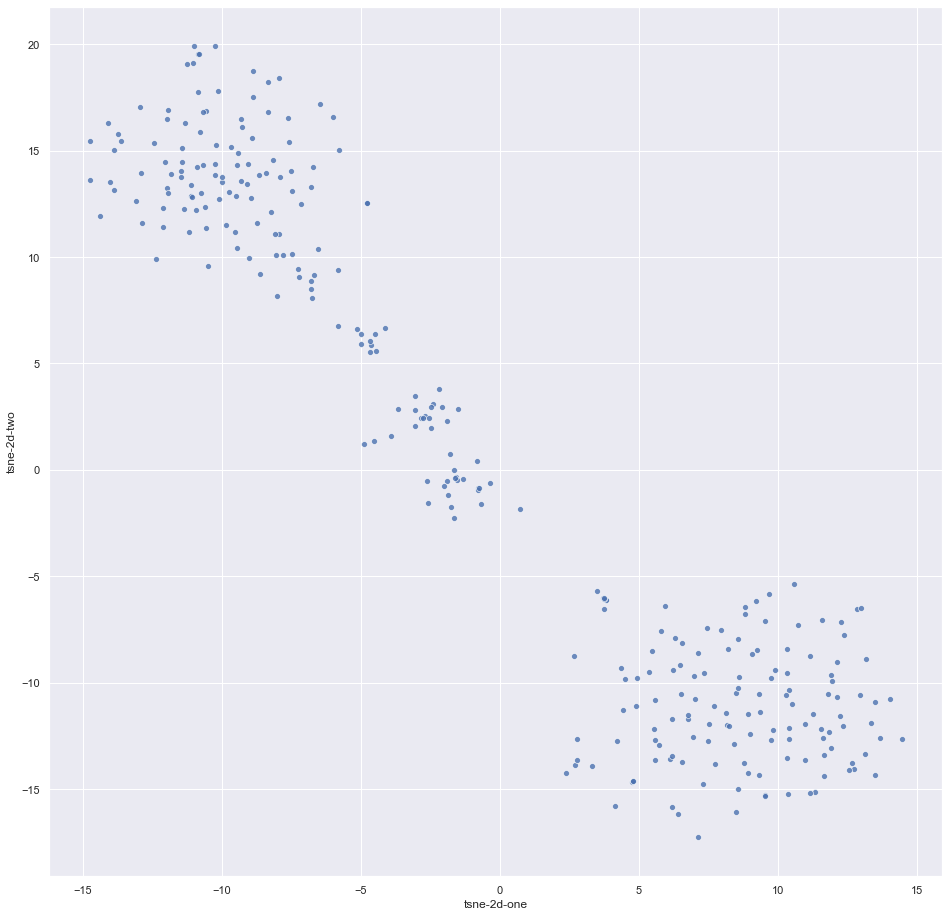

In [129]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.8
)
plt.show()

# Clustering

In [130]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc)).labels_.astype(float)

silhouette_list = []
for k in range(2, 15, 1):
    latent_clusters = cluster_cosine(X_doc, k)
    silhouette_avg = silhouette_score(X_doc, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

Silhouette score for 2 clusters is : 0.3884
Silhouette score for 3 clusters is : 0.4039
Silhouette score for 4 clusters is : 0.3533
Silhouette score for 5 clusters is : 0.2421
Silhouette score for 6 clusters is : 0.2449
Silhouette score for 7 clusters is : 0.3208
Silhouette score for 8 clusters is : 0.2319
Silhouette score for 9 clusters is : 0.239
Silhouette score for 10 clusters is : 0.2484
Silhouette score for 11 clusters is : 0.2338
Silhouette score for 12 clusters is : 0.2204
Silhouette score for 13 clusters is : 0.1464
Silhouette score for 14 clusters is : 0.2164


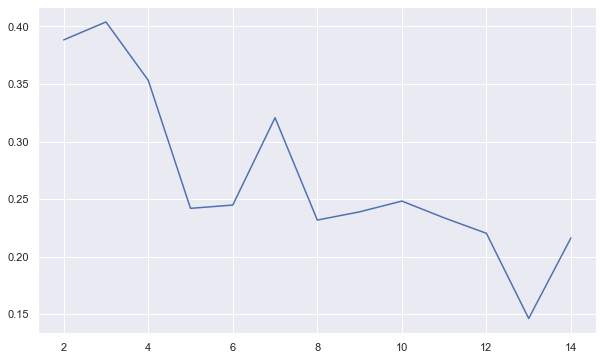

In [131]:
plt.figure(figsize=(10,6))
plt.plot(range(2,15,1), silhouette_list);

In [132]:
N_CLUSTER = 6

latent_clusters = cluster_cosine(X_doc, N_CLUSTER)
doc_vec_end = df_senator2vec.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

0.0    111
1.0     66
5.0     38
3.0     34
4.0     27
2.0     19
Name: label, dtype: int64

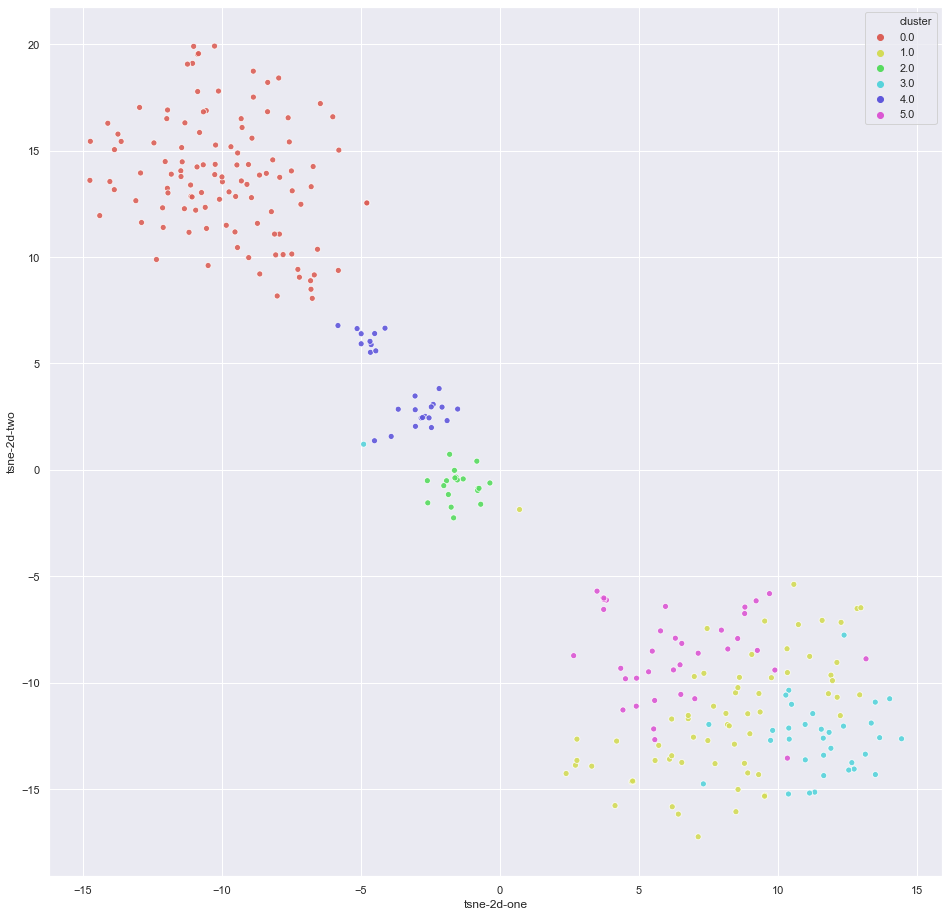

In [133]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.9
);
plt.show();

# <font color='red'>Trial 2</font>
- iteration = 10
- epochs = 500

# Map tag and tag vector

In [102]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
doc_vector_dict = {arg : doc_model.docvecs[arg] for arg in vocab_doc}

In [103]:
df_senator2vec = pd.DataFrame(doc_vector_dict).T
df_senator2vec

0          1          2          3          4          5          6          7         8          9         10         11         12         13         14         15         16         17         18         19        20         21        22        23         24         25         26         27         28         29         30         31         32         33        34         35         36         37         38        39         40         41        42        43         44         45         46         47         48         49         50         51         52         53         54         55         56         57        58        59         60         61         62         63         64         65        66         67         68         69         70        71         72         73         74         75         76         77         78         79         80         81         82         83         84         85         86         87        88        89         90  \
1    -5.700203  -2.376045  -2.061863   0.125058   3.218442   1.367497   1.875833   2.046722  1.051488   2.892191   4.141191  -3.974046   3.292539   3.241334   1.180585  -0.808525  -0.581632  -3.644481   4.104706   1.893902 -1.249978   3.611241  3.243271  2.696566   3.294704   0.021980   7.657819  -1.020107   1.766244  -2.981791  -4.753133  -1.515980   2.404382   3.669182  1.927094  -3.274134  -2.336218   5.065167   5.232179 -1.196696   1.611731   6.749683 -2.057239  1.563400   1.320215   1.316747   1.209538   1.150449  -2.992151   0.820824  -1.442539  -0.130815  -1.049578   6.770050  -0.447748  -4.962906   4.882413   7.583957 -5.954647 -0.391822   0.975569  -3.073500   1.910711  -5.234532  -1.426283   0.756368 -1.027937   0.022537   1.073701  -2.713948  -0.856656 -2.117677   1.134877  -6.153671  -4.066161   0.556968  -0.541207  -6.282664  -1.562095  -2.189871  -1.370232  -0.622250   3.402979  -1.899050   2.065843   6.763608   2.829964   2.852847 -1.443714 -1.761094   0.975162   
2     5.039113   1.574237   6.336648  -2.320561  -1.286530  -3.863449   0.728970  -5.308528 -3.985203  -0.371361  -2.753298  -1.442828   4.741365   2.988613  -4.924703  -6.290452   5.356938  -0.282581  -3.620034   1.465317 -5.500870  12.452872 -4.223958  1.199077   5.005898  -3.160414   3.133713   0.239249   7.124764   2.540188  -0.962998  -4.094547   1.801741   1.353498 -1.197592   1.004542   8.646423   5.005892   1.291785  1.661348  -6.527711   4.738806 -3.580274 -0.803722  -1.441733   5.155169   2.272437  -5.484362 -10.313470  -2.071074   3.282628  -0.089589  -6.487647   8.151580  -4.870693   0.963345   0.511338  -0.262691  6.317261  6.183150  -3.122195  -0.942545  -0.799190  -1.872125   7.682796   1.266672 -0.685069  -5.863260   3.331447   4.056946  -9.490891 -0.616233  -4.538588  -3.918507  -2.332086   6.262480   7.414343  -9.113181  -6.473959   1.414496   0.745623   0.718820   4.808978  -0.012417   3.660290  -4.312337   0.959076   7.005009 -1.412918 -4.233759   4.828265   
3    -3.182545  -2.672920  -7.463625   2.924825  -0.706228  -3.041012   4.565566   2.660538 -0.291579   0.165302   0.944162  -5.875059  -0.792868   2.288033   2.062416  -5.836595   0.344952  -5.007195 -11.245511  -4.766821 -2.222765   6.830940 -0.473824  0.293105   1.400962   0.973265   0.022702   1.752814   2.305459  -3.447684   4.196213   0.727443  -1.209193   0.291805  2.220691  -5.087247   7.472857   3.847178   6.606289 -0.607765  -0.501725   9.152304 -2.363045  9.818805   5.787419  -2.693769  -1.299936  -4.351117  -1.328333   0.598345  -1.237813  -4.265142  -6.632852  11.285295  -8.257833  -1.047847  -6.651386  -0.656977 -1.187658  5.345964  -3.949227  -2.431524  -3.068920   0.247279  -0.565000   1.941594 -0.631857  -2.639194   2.639592  -9.259387  -2.325687  0.037762   2.745997  -4.702238  -3.109631  -5.192809   0.148754  -0.073023   1.380707  -1.891336   2.466222  -2.031595  -4.457594  -3.668383   6.151577  -0.107852  -2.466652   8.947309 -0.943492  1.051137   1.579570   
4     3.004504   4.348977  -1.696744 

In [104]:
X_doc = pd.DataFrame(doc_vector_dict).T.values
X_doc

array([[ -5.7002034 ,  -2.376045  ,  -2.0618632 , ...,   1.900989  ,
         -6.973315  ,  -4.5277414 ],
       [  5.0391126 ,   1.5742368 ,   6.3366475 , ...,   5.1052475 ,
        -11.8041525 ,  -6.8776045 ],
       [ -3.1825447 ,  -2.6729205 ,  -7.463625  , ...,   1.8379568 ,
         -7.805176  ,   0.05437949],
       ...,
       [ -3.3754716 ,   4.155169  ,  -5.808124  , ...,   5.1770205 ,
         -0.752488  ,   0.41420463],
       [  0.78540987,   4.1465826 ,   0.99263084, ...,  -2.3028142 ,
         -7.8301506 ,  -0.08524645],
       [  3.7648232 ,   3.6683378 ,  -0.09161425, ...,   0.22804536,
         -8.350559  ,   0.21351491]], dtype=float32)

# Visualizing with T-sne

In [105]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc, X_doc, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 295 samples in 0.000s...
[t-SNE] Computed neighbors for 295 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 295 / 295
[t-SNE] Mean sigma: 0.175237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.638832
[t-SNE] KL divergence after 500 iterations: 1.832567


In [106]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 1152x1152 with 0 Axes>

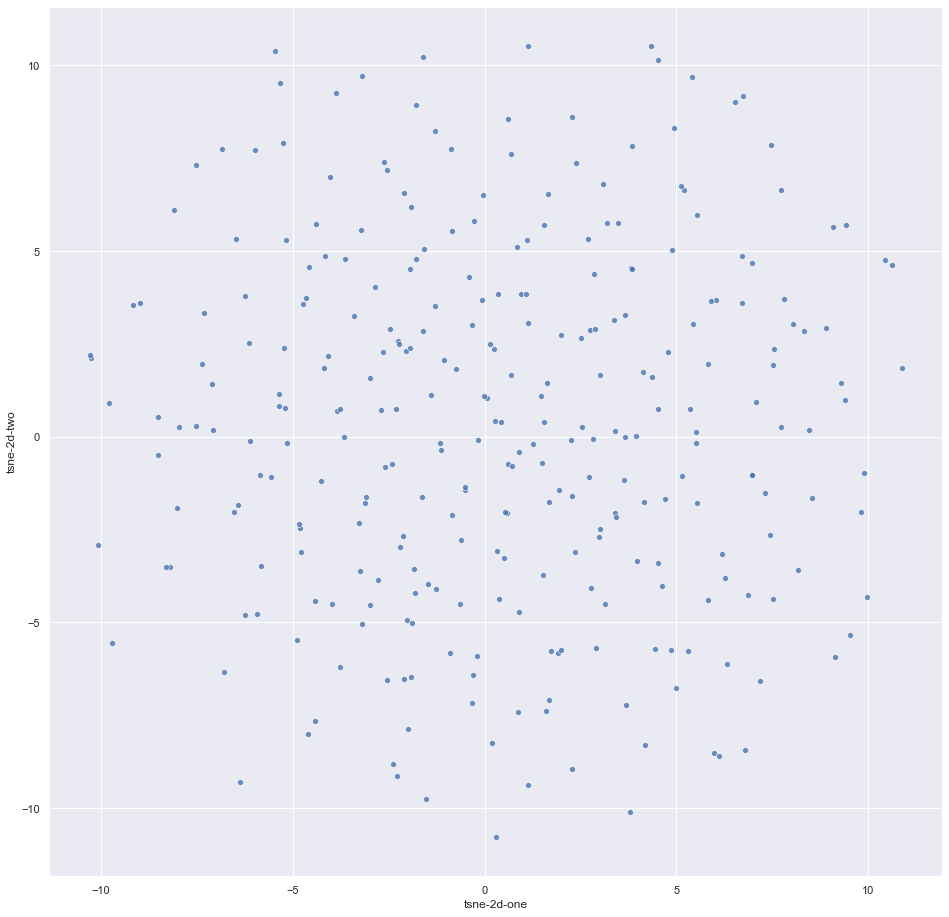

In [107]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.8
)
plt.show()

# Clustering

In [108]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc)).labels_.astype(float)

silhouette_list = []
for k in range(2, 15, 1):
    latent_clusters = cluster_cosine(X_doc, k)
    silhouette_avg = silhouette_score(X_doc, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

Silhouette score for 2 clusters is : 0.01929
Silhouette score for 3 clusters is : 0.01867
Silhouette score for 4 clusters is : 0.01488
Silhouette score for 5 clusters is : 0.01311
Silhouette score for 6 clusters is : 0.01557
Silhouette score for 7 clusters is : 0.0132
Silhouette score for 8 clusters is : 0.009336
Silhouette score for 9 clusters is : 0.01071
Silhouette score for 10 clusters is : 0.01083
Silhouette score for 11 clusters is : 0.00425
Silhouette score for 12 clusters is : 0.005932
Silhouette score for 13 clusters is : 0.004178
Silhouette score for 14 clusters is : 0.007703


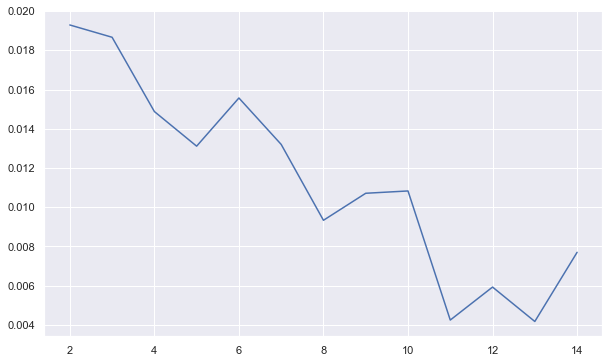

In [109]:
plt.figure(figsize=(10,6))
plt.plot(range(2,15,1), silhouette_list);

In [110]:
N_CLUSTER = 6

latent_clusters = cluster_cosine(X_doc, N_CLUSTER)
doc_vec_end = df_senator2vec.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

1.0    78
5.0    52
4.0    47
0.0    46
3.0    39
2.0    33
Name: label, dtype: int64

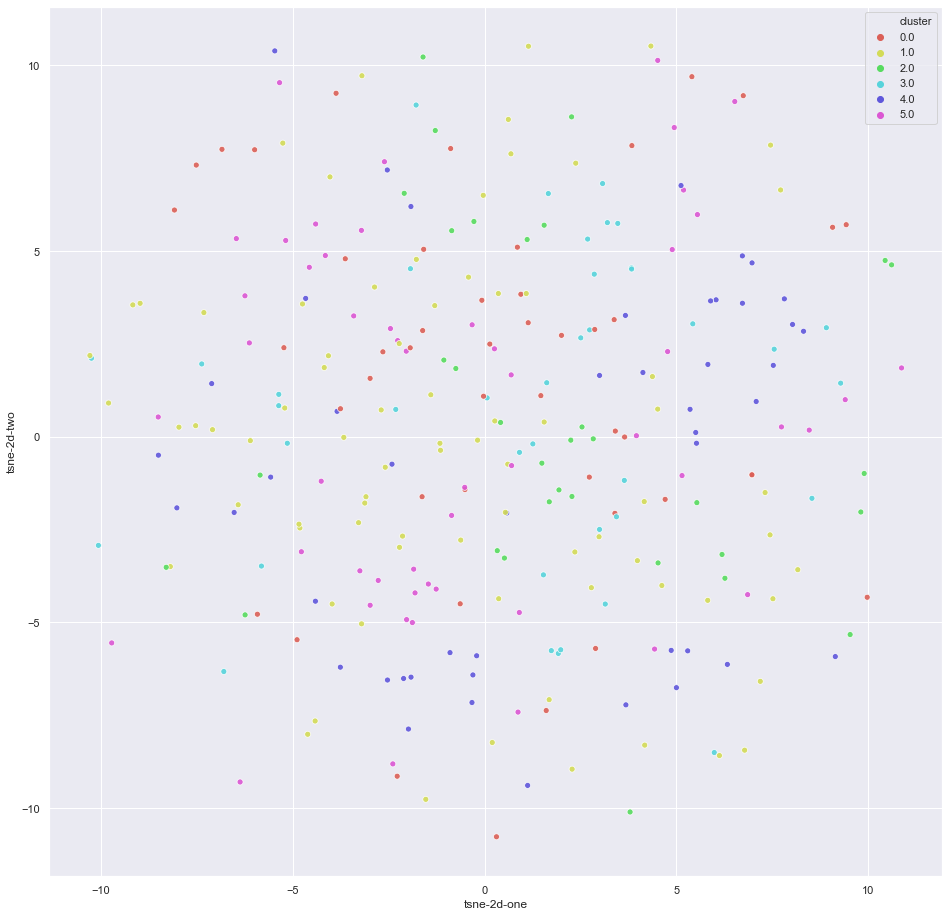

In [111]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.9
);
plt.show();

# <font color='red'>Trial 3</font>
- iteration = 5
- epochs = 100

# Map tag and tag vector

In [113]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
doc_vector_dict = {arg : doc_model.docvecs[arg] for arg in vocab_doc}

In [114]:
df_senator2vec = pd.DataFrame(doc_vector_dict).T
df_senator2vec

0         1         2          3          4         5         6         7         8          9         10         11         12        13        14         15        16        17         18         19        20         21        22        23        24         25        26         27         28         29         30        31         32        33        34         35        36         37         38        39         40         41        42        43         44        45        46         47         48         49        50        51         52        53        54        55        56         57        58        59        60        61        62         63        64         65         66        67        68         69         70        71        72         73        74        75         76         77        78        79         80        81        82        83        84        85        86         87         88        89         90        91        92        93         94  \
1   -3.722566 -1.903128 -0.178749   0.434697   1.356380  2.070287  2.586404  3.178504  0.664052   4.238605   2.126416  -3.169574   1.360615  2.154987  0.900415  -0.541414 -1.176062 -3.841689   3.598354  -0.390545 -0.954534   2.896534  2.942848  1.018172  0.394049  -0.456933  5.355318   0.107371   1.821283  -2.954007  -3.800351  0.517494   0.574879  3.572798  1.073140  -0.817948 -3.914426   5.197734   3.323601  1.516723   0.901403   4.626467 -3.701579  0.701971   0.055769  1.189536  0.557886   0.031270  -2.700765   1.600028 -1.316062  0.378176  -0.710389  3.081036 -0.799298 -4.474476  3.305717   5.814973 -3.768364 -2.323798  0.742772 -1.930067  2.673426  -2.410262 -0.802043   1.947819   0.414063  1.355949  1.280132  -1.710407  -0.303822  0.417713 -0.790822  -1.684948 -2.140050  0.550211  -1.567933  -3.998964 -2.937693 -0.407848  -0.363825 -0.764347  2.926590 -0.970076  0.551895  4.839911  2.216366  -0.062986  -0.410684 -2.264307   1.189509  0.169911  2.789114  1.564183  -0.862211   
2    0.397042  1.128120  4.763964  -4.794174  -2.871534 -2.747752  0.150933  0.411910 -0.536820  -2.816051  -1.748983   1.900100   4.188024  1.916339 -4.562909  -4.424705  1.533858  0.810745  -2.884014   2.844249 -3.742643  12.425933  0.530877 -0.761500  4.164595  -4.793159 -0.470757   0.842654   4.128050   1.567591  -1.584581 -3.549173   2.121457  0.221663 -2.458812  -1.952923  4.507646   4.378172   3.162853  3.029488  -5.187339   2.334265 -1.282831 -0.416417  -1.707528  6.046047  0.741263  -3.849510  -6.679757  -0.229071  3.181849 -0.070260  -2.600290  3.516464 -2.310837 -1.740069  1.039030  -1.396056  4.412448  2.121514 -3.645072 -3.083518 -2.083238  -0.669234  3.069864   0.577201   1.047089 -6.873235 -1.425403   4.178851  -8.141611 -0.663857 -5.557553  -2.369241 -2.504667  5.664067   4.321490  -6.951421 -2.903373  2.411350   1.089979  1.467636  3.183820 -2.249452  2.138675 -3.340919  3.320616   6.097903  -2.058220 -0.354277   5.926890 -2.915494 -2.532372  7.495625   1.899661   
3   -3.197669 -1.428831 -4.942509   2.220554   0.479827 -3.225341  2.149837  1.800995  0.231633   0.067105   2.598894  -6.444466   1.099263  2.250650 -0.023056  -3.775001 -0.402623 -6.933735  -8.345408  -2.950757 -2.789675   3.382586  0.184371 -2.612658 -2.670850   1.413644 -0.634652   1.078007   4.914127  -4.950753   3.164246 -1.719136  -0.827998  0.655517  4.384277  -4.999539  4.075149   1.689970   4.323535 -1.764230   0.610216   5.919217 -1.279283  7.340418   1.889911 -0.308815 -0.750982  -3.353568  -1.302584   1.929149 -0.949790 -1.754738  -1.633185  7.775616 -6.049014  0.439305 -6.564719   1.847711 -1.067673  5.059324 -3.511955 -1.432124 -2.317132  -0.843035 -2.917667   2.014895   1.002039  0.130694  1.828264  -6.416411  -0.783963 -1.136210  0.218936  -1.367054 -1.862398 -4.048835  -1.226444  -3.761116  5.293676 -0.861879   0.435456 -0.543628 -4.106652 -1.412575  4.024991  1.695778 -0.857791   3.986330  -0.433743  0.973550   1.485038 -2.731776  0.225025 -0.058093   4.119363   
4    1.310467  2.883248 

In [115]:
X_doc = pd.DataFrame(doc_vector_dict).T.values
X_doc

array([[-3.7225657 , -1.9031284 , -0.17874914, ...,  1.1612564 ,
        -4.1627502 , -2.765013  ],
       [ 0.39704236,  1.1281196 ,  4.7639637 , ...,  6.732102  ,
        -7.062265  , -1.5353136 ],
       [-3.1976693 , -1.4288311 , -4.942509  , ..., -0.96392536,
        -4.4799666 ,  1.8138357 ],
       ...,
       [-1.3969597 ,  3.4545481 , -6.9693613 , ...,  2.2659488 ,
        -0.7346406 , -2.342199  ],
       [-1.4169606 ,  2.517033  ,  0.62202823, ..., -2.3970566 ,
        -5.8082776 , -0.7199722 ],
       [ 0.43975675,  2.8798902 ,  0.08065392, ...,  0.20459309,
        -5.694038  ,  1.8538907 ]], dtype=float32)

# Visualizing with T-sne

In [116]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc, X_doc, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 295 samples in 0.000s...
[t-SNE] Computed neighbors for 295 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 295 / 295
[t-SNE] Mean sigma: 0.214563
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.565285
[t-SNE] KL divergence after 500 iterations: 1.402519


In [117]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 1152x1152 with 0 Axes>

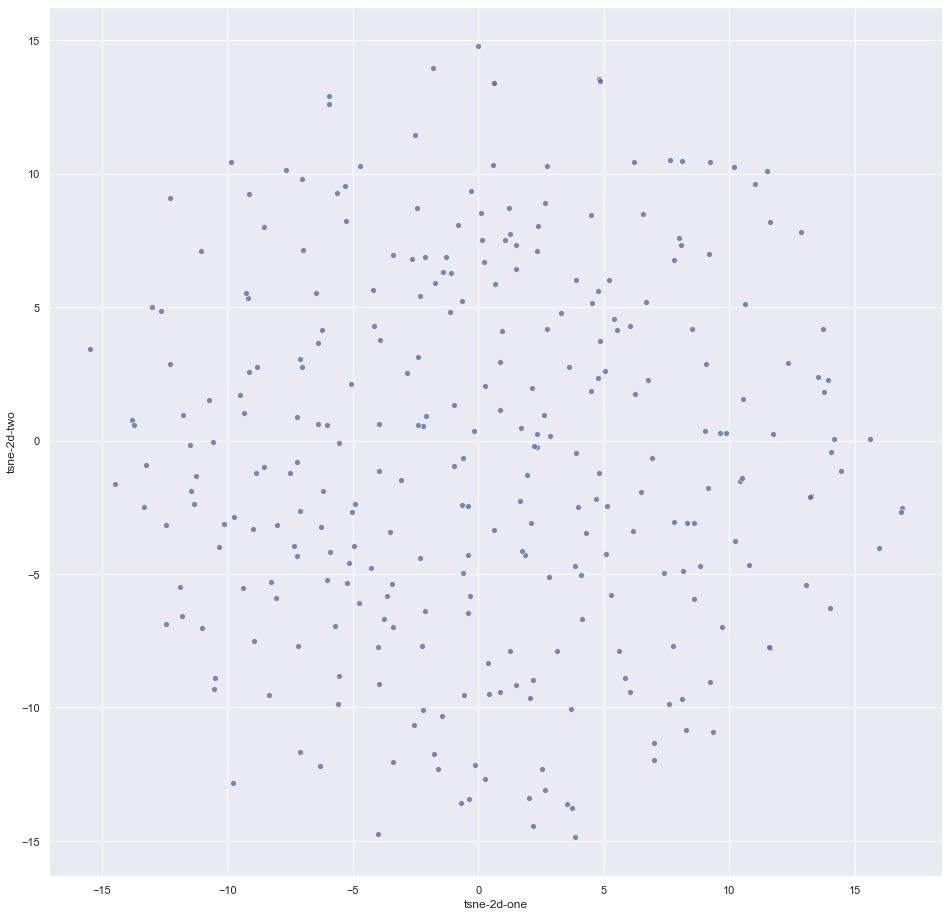

In [118]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.8
)
plt.show()

# Clustering

In [119]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc)).labels_.astype(float)

silhouette_list = []
for k in range(2, 15, 1):
    latent_clusters = cluster_cosine(X_doc, k)
    silhouette_avg = silhouette_score(X_doc, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

Silhouette score for 2 clusters is : 0.03844
Silhouette score for 3 clusters is : 0.03797
Silhouette score for 4 clusters is : 0.0382
Silhouette score for 5 clusters is : 0.04161
Silhouette score for 6 clusters is : 0.04322
Silhouette score for 7 clusters is : 0.043
Silhouette score for 8 clusters is : 0.03579
Silhouette score for 9 clusters is : 0.04448
Silhouette score for 10 clusters is : 0.01991
Silhouette score for 11 clusters is : 0.04713
Silhouette score for 12 clusters is : 0.04659
Silhouette score for 13 clusters is : 0.03443
Silhouette score for 14 clusters is : 0.0469


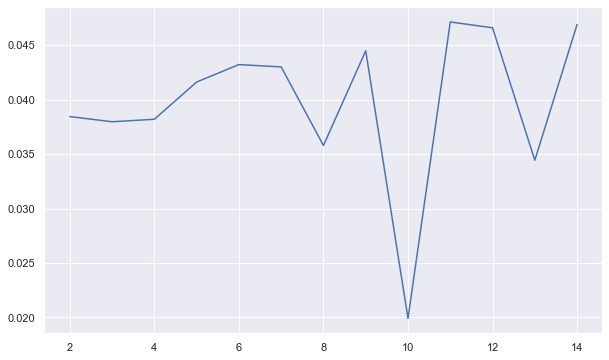

In [120]:
plt.figure(figsize=(10,6))
plt.plot(range(2,15,1), silhouette_list);

In [121]:
N_CLUSTER = 6

latent_clusters = cluster_cosine(X_doc, N_CLUSTER)
doc_vec_end = df_senator2vec.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

0.0    56
5.0    56
3.0    50
4.0    49
1.0    45
2.0    39
Name: label, dtype: int64

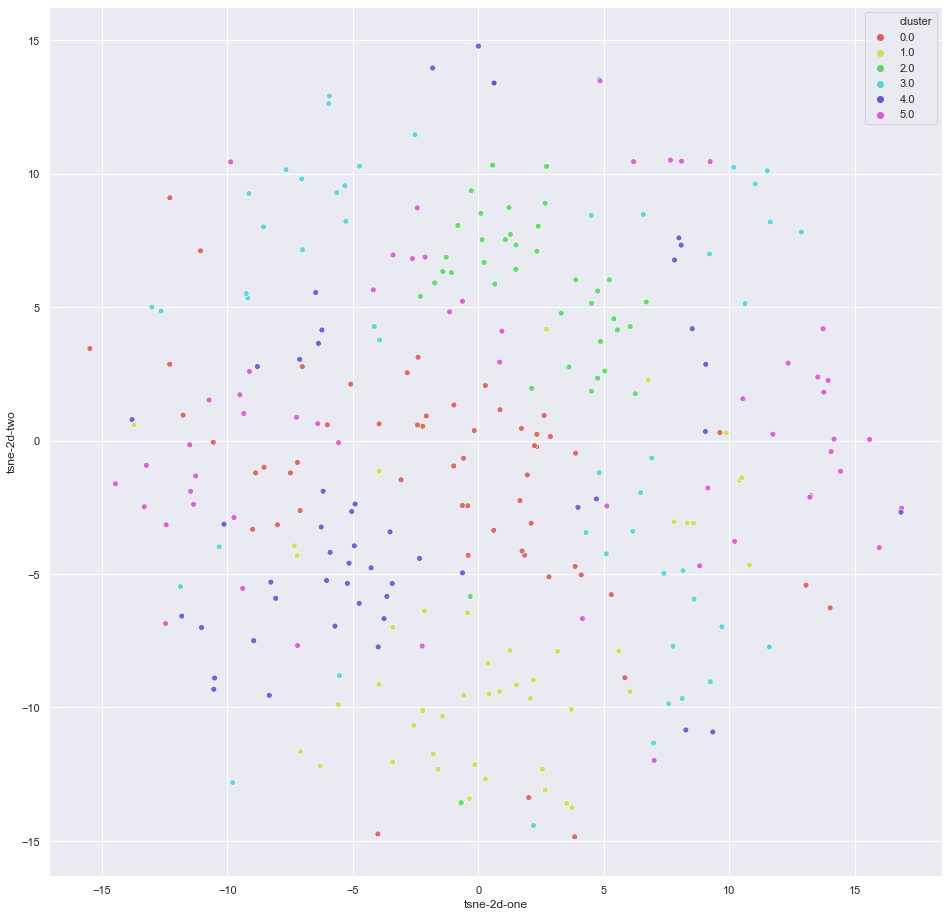

In [122]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.9
);
plt.show();